
# Week 2 — Baseline Prediction Models & Evaluation

In this notebook, you will build **baseline prediction models** for financial
returns and evaluate them using **strictly forward-looking (time-series)
validation**.

This week focuses on **evaluation discipline**, not on maximizing performance.


## 1. Imports

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

plt.style.use("seaborn-v0_8")



## 2. Load data from Week 1

- Reuse the data you created in Week 1.
- You can use one stock of your choice (you can repeat it for multiple stocks if you want and plot them separately)
- Take a long term horizon data set (5-10 years)


In [2]:
%pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
   ---------------------------------------- 0.0/127.1 kB ? eta -:--:--
   --------- ----------------------------- 30.7/127.1 kB 660.6 kB/s eta 0:00:01
   ---------------------------------------- 127.1/127.1 kB 1.5 MB/s eta 0:00:00
Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl (1.6 MB)
   ---------------------------------------- 0.0/411.9 kB ? eta -:--:--
   ---------------------------------------- 411.9/411.9 kB 8.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/178.7 kB ? eta -:--:--
   --------------------------------------- 178.7/178.7 kB 11.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [4]:

# TODO: load prices and returns from Week 1
tickers = ["AAPL", "MSFT", "GOOG", "AMZN", "TSLA"]

import yfinance as yf
long_term_data=yf.download(tickers,start="2015-01-01",end="2024-01-01", auto_adjust=False)
long_term_data = long_term_data.dropna()
# print("testing")


[*********************100%***********************]  5 of 5 completed



## 3. Feature construction

Required features:
- $r_t$
- $r_{t-1}$
- 20-day rolling mean
- 20-day rolling volatility
- 5-day momentum


In [5]:
prices=long_term_data['Adj Close']
r_t=np.log(prices).diff().dropna()
r_tminus1=r_t.shift(1).dropna()
# print(r_tminus1)
# print(r_t)

rollingmean=r_t.rolling(window=20).mean()
rollingvol=r_t.rolling(window=20).std()
momentum=r_t.rolling(window=5).mean()
print(rollingmean.shape)
rollingmean.shape==r_t.shape and rollingvol.shape==r_t.shape and momentum.shape==r_t.shape


(2263, 5)


True


## 4. Naive baselines


In [6]:

# TODO: zero predictor

zero_pred=np.zeros_like(r_t)

In [7]:
# TODO: rolling mean predictor

rollingmean_pred=rollingmean


## 5. Linear models (OLS & Ridge)
Suggested that you review basic linear regression theory as well (resources given in README).

In [8]:
models={}
datasets={}
for ticker in tickers:
    X = pd.DataFrame({
        "r_t": r_t[ticker],
        "r_t-1": r_tminus1[ticker],
        "roll_mean_20": rollingmean[ticker],
        "roll_vol_20": rollingvol[ticker],
        "momentum_5": momentum[ticker],
    })
    y=r_t[ticker].shift(-1).dropna().rename("next")
    print(y.shape)
    data=pd.concat([X,y],axis=1).dropna()

    X_final=data[["r_t", "r_t-1", "roll_mean_20", "roll_vol_20", "momentum_5"]]
    y_final=data["next"]

    datasets[ticker]=(X_final,y_final)



(2262,)
(2262,)
(2262,)
(2262,)
(2262,)



## 6. Tree-based model (Random Forest) (optional)


In [9]:

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    min_samples_leaf=50,
    random_state=42
)



## 7. Walk-forward evaluation

- Scikit reference for [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).

In [10]:

# TODO: implement TimeSeriesSplit evaluation

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

tscv=TimeSeriesSplit(n_splits=5)

allresults={}
alloospreds={}

for ticker in tickers:
    X_final,y_final=datasets[ticker]


    oos_pred = {
        "zero": pd.Series(index=X_final.index, dtype=float),
        "rollmean": pd.Series(index=X_final.index, dtype=float),
        "ols": pd.Series(index=X_final.index, dtype=float),
    }

    for train_idx, test_idx in tscv.split(X_final):
        X_train, X_test = X_final.iloc[train_idx], X_final.iloc[test_idx]
        y_train, y_test = y_final.iloc[train_idx], y_final.iloc[test_idx]

        oos_pred["zero"].iloc[test_idx] = 0.0
        oos_pred["rollmean"].iloc[test_idx] = X_test["roll_mean_20"].values

        ols = LinearRegression()
        ols.fit(X_train, y_train)
        oos_pred["ols"].iloc[test_idx] = ols.predict(X_test)


    final_rmse = {}
    for name, series in oos_pred.items():
        series = series.dropna()
        y_true = y_final.loc[series.index]
        final_rmse[name] = rmse(y_true, series)

    allresults[ticker] = final_rmse
    alloospreds[ticker] = oos_pred

    print(f"\n{ticker} OOS RMSE:")
    for k, v in final_rmse.items():
        print(f"{k}: {v:.6f}")


AAPL OOS RMSE:
zero: 0.018617
rollmean: 0.018985
ols: 0.018704

MSFT OOS RMSE:
zero: 0.017593
rollmean: 0.018056
ols: 0.017569

GOOG OOS RMSE:
zero: 0.018222
rollmean: 0.018722
ols: 0.018343

AMZN OOS RMSE:
zero: 0.020847
rollmean: 0.021360
ols: 0.020891

TSLA OOS RMSE:
zero: 0.037266
rollmean: 0.038172
ols: 0.037417



## 8. Prediction accuracy


In [11]:

# TODO: compute RMSE for all models and compare them

print("already done in prev block")

already done in prev block


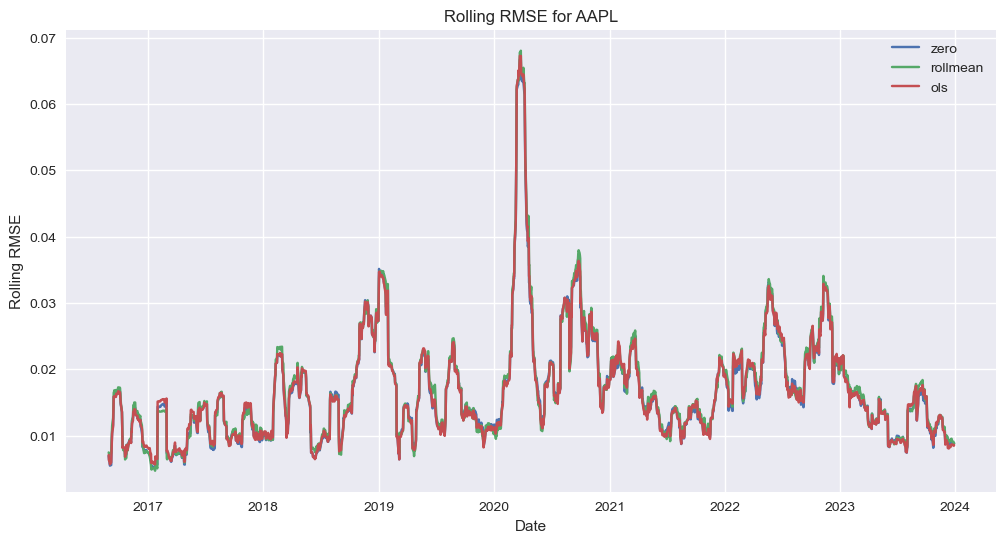

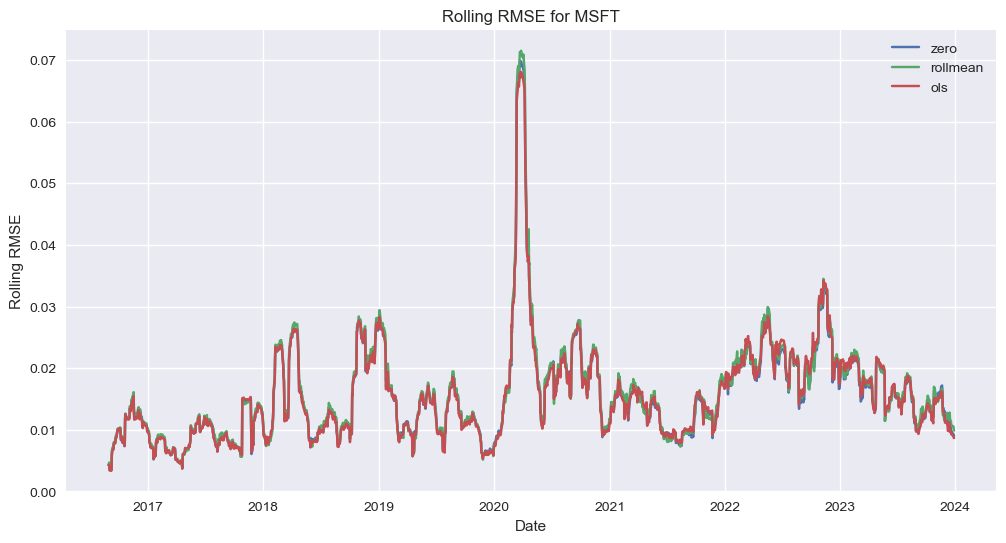

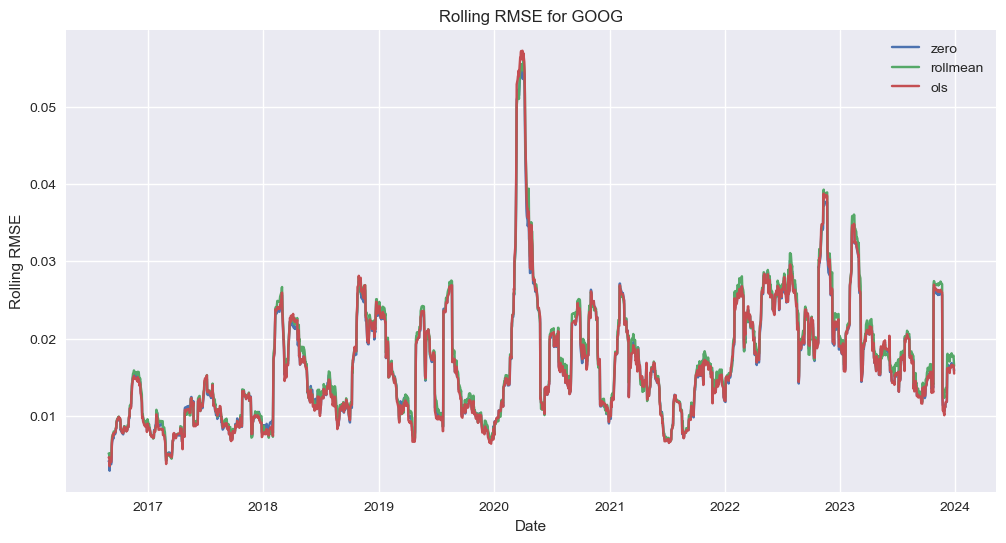

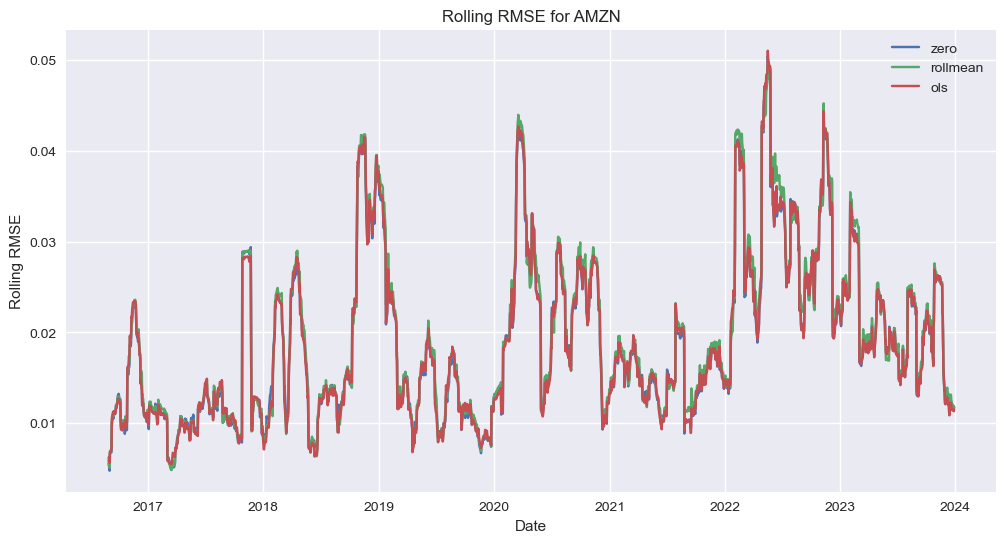

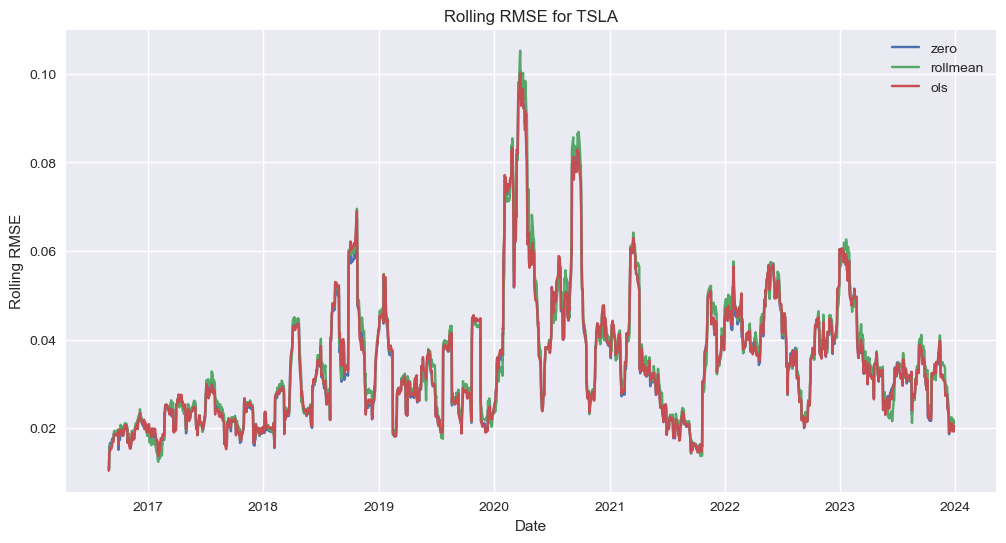

In [12]:
# TODO: plot rolling RMSE vs time for all models to compare their performance across different time periods/regimes
for ticker in tickers:
    oos_pred = alloospreds[ticker]
    y_final = datasets[ticker][1]

    rolling_rmse={}
    window_size=20
    for name,series in oos_pred.items():
        series=series.dropna()
        y_true=y_final.loc[series.index]
        rmse_series=(y_true-series)**2
        rolling_rmse[name]=rmse_series.rolling(window=window_size).mean().apply(np.sqrt)

    plt.figure(figsize=(12, 6))
    for name, rmse_series in rolling_rmse.items():
        plt.plot(rmse_series.index, rmse_series, label=name)
    plt.title(f'Rolling RMSE for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Rolling RMSE')
    plt.legend()
    plt.show()

In [13]:
# Bonus: compute volatility scaled/normalized prediction error: sqrt( ((y_true - y_pred)**2) / (vol_t**2) ) - and compare across models


## 9. Bonus: Looking at a toy strategy based on predictions
Define a simple "all-in" strategy where you go all long (+1) when you predict the stock to be going up, and all short (-1) when you predict the stock to be going down
$$
\text{position}_t = \text{sign}(y_\text{pred})
$$
Then, your returns for the $t$-th day (assuming daily returns) will be $(\text{position}_t \times y_\text{true})$ (note $y_\text{true} = r_t$).

Note that this is extremely simplistic and ignore any predictions related magnitude of expected returns, or expected volatility data etc. It is used only as a demonstration of what a prediction-based strategy may look like.

**Plot your returns using this strategy based on all the models above and compare them!**

In [14]:
# TODO: compute the positions for each model and daily returns


In [15]:
# TODO: plot your returns


## 10. Discussion questions

1. Why do we need naive baselines?
2. How does the evaluation strategy here (walk-forward evaluation) differ from the random training-test dataset splits used in convention ML?
3. *(Addon)* And, why does random splitting technique fail here?
4. Interpret the RMSE values and rolling RMSE plot results very briefly.
5. *(Addon)* Are there periods where model performance degrades noticeably? What might this indicate?
6. Why might Random Forest overfit?
7. *(Bonus)* Two models have similar RMSE, but one makes larger errors primarily during high-volatility periods. Why might this model be *less dangerous* in a portfolio context?

1. Naive baselines tell us how hard the problem actually is, and help us to find out if there even is a problem worth solving here. If a complex model can’t beat a simple baseline by a meaningful amoutn, then it’s not an actual solution.

2. Walk-forward evaluation trains on past data, tests on future data, respects time ordering. If we were to use ML-like splits here, we would either have way less data to train our model if we split the time interval at some point or, more worryingly, allowing testing data to seep into training data, giving too optimistic estimates for error pct.

3. Market behavior can change over time, and random splits allow the model to train on future data as well, leading to misleading evaluation results.

4. The RMSE values across models are generally similar, indicating that daily stock returns are difficult to predict. Small improvements over naive baselines are seen to be marginal. Rolling RMSE plots show how prediction error evolves over time, with spikes typically corresponding to periods of increased market volatility.

5. Yes,there are clear periods where RMSE increases sharply. These usually coincide with market stress, high volatility. During such periods, relationships learned from historical data break down, and linear models struggle to adapt quickly, leading to worsee predictive performance.

In [ ]:
from helpers import save_predictions

returns_df = r_t[tickers].dropna()

mu_hat = returns_df.tail(60).mean().values  
Sigma_hat = np.cov(returns_df.tail(252).values, rowvar=False)  

Sigma_hat = 0.5 * (Sigma_hat + Sigma_hat.T) + 1e-8 * np.eye(len(tickers))

save_predictions(mu_hat, Sigma_hat, tickers, path="predictions.npz")

print("Saved:", "predictions.npz")
print("mu_hat shape:", mu_hat.shape, "| Sigma_hat shape:", Sigma_hat.shape)


Saved: predictions.npz
mu_hat shape: (5,) | Sigma_hat shape: (5, 5)
